#### Imports

In [1]:
!pip install --upgrade --force-reinstall shap

  Using cached shap-0.39.0-cp37-cp37m-win_amd64.whl (414 kB)
  Using cached scikit_learn-0.24.2-cp37-cp37m-win_amd64.whl (6.8 MB)
  Using cached pandas-1.2.4-cp37-cp37m-win_amd64.whl (9.1 MB)
  Using cached numpy-1.20.3-cp37-cp37m-win_amd64.whl (13.6 MB)
  Using cached tqdm-4.61.0-py2.py3-none-any.whl (75 kB)
  Using cached cloudpickle-1.6.0-py3-none-any.whl (23 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Using cached numba-0.53.1-cp37-cp37m-win_amd64.whl (2.3 MB)
  Using cached scipy-1.6.3-cp37-cp37m-win_amd64.whl (32.6 MB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)
  Using cached llvmlite-0.36.0-cp37-cp37m-win_amd64.whl (16.0 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling nu

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement h5py<2.11.0,>=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.20.3 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.6.3 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.



    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Uninstalling python-dateutil-2.8.1:
      Successfully uninstalled python-dateutil-2.8.1
  Attempting uninstall: pytz
    Found existing installation: pytz 2019.3
    Uninstalling pytz-2019.3:
      Successfully uninstalled pytz-2019.3
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.42.1
    Uninstalling tqdm-4.42.1:
      Successfully uninstalled tqdm-4.42.1
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.6.0
    Uninstalling cloudpickle-1.6.0:
      S

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean, cosine

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, homogeneity_score, v_measure_score, completeness_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py
import seaborn as sns
import shap

pd.set_option('display.max_colwidth', 1000)

In [7]:
shap.plots.text

<function shap.plots._text.text(shap_values, num_starting_labels=0, group_threshold=1, separator='', xmin=None, xmax=None, cmax=None)>

#### View dataset

In [3]:
df = pd.read_csv('../datasets/gao_dataset.csv')
print(df.shape)
df.head(10)

(1127, 3)


,index,label,text
0,481,0,The Supemes have decide discrimination is just fine as long as it is reversed
1,482,0,If you dont understand what transgender is go talk to your family doctor They cover it in medical school
2,483,0,im not understanding this kidnapping point Be real Other countries took by force their own people and sold them for a coin Stop attempting to portray this country as being the only one that participated in this evil trade
3,484,0,Cut off Federal funding and arrest anyone getting in the way for aiding and abetting obstruction of justice and everything else that might stick
4,485,0,Question hasnt any other First Lady taken swipes at their opponent Party s presidential candidates For goodness sake this is a College Commencement speech show just a little class Michele This again reveals her lack of grace and integrity as our nation s First Lady
5,486,0,Couldn t agree more Great comment
6,488,0,There are many people who are mad at the white parents They shrugged off the sign and decided to go into the water The water could have had bacteria or amebas or some other danger The gorilla enclosure was a clear hazard and as every parent knows kids are quick
7,489,0,Funny some people cannot see why Blacks are offended by the confederate flag It just amazes me The whole purpose of the confederacy and its constituiton was to allow the continued enslavement of Black people No state could be apart of the confederacy unless they allowed the practice of slavery If you do not believe that then I strongly urge you to read both the US and confederate constitution The whole purpose of the civil war was to continue the horrible act of slavery in the south With that I say now to take the rag down and put it in a museum
8,490,0,hard to have respect for someone who in a multi figure a year job in an Chicago hospital was on the committee that worked on a poor patient dumping scheme
9,491,0,Why the lies


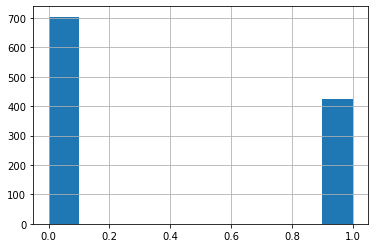

In [4]:
df["label"].hist()

In [8]:
x = df['text'].values
y = df['label'].values

#### Word representation
We are going to use TF*IDF (Term frequency- Inverse document frequency) vectorizer to convert our text into numbers.

TF = Frequency of term

IDF = No of docs/ No of docs with the term

In [9]:
tfid = TfidfVectorizer(max_features=5000)
x = tfid.fit_transform(x).toarray()
x.shape

(1127, 4813)

In [10]:
tfid.get_feature_names()

['abeting',
 'abetting',
 'abhorrent',
 'abiding',
 'ability',
 'able',
 'aboard',
 'abolish',
 'abort',
 'aborted',
 'abortion',
 'abortions',
 'about',
 'above',
 'abraham',
 'abridging',
 'abroad',
 'absence',
 'absolutely',
 'abuse',
 'abused',
 'abuses',
 'abusing',
 'abusive',
 'academic',
 'accentuated',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accident',
 'accidents',
 'acclimate',
 'accommodating',
 'accompanied',
 'accomplice',
 'accorded',
 'according',
 'accordingly',
 'accountable',
 'accuracy',
 'accurate',
 'accusations',
 'achieve',
 'achieving',
 'acknowledge',
 'aclu',
 'acronym',
 'across',
 'act',
 'acting',
 'action',
 'actions',
 'active',
 'activist',
 'activities',
 'acts',
 'actual',
 'actually',
 'ad',
 'add',
 'added',
 'address',
 'addresses',
 'adjusted',
 'admin',
 'administration',
 'admissions',
 'admit',
 'admitted',
 'admitting',
 'adolescents',
 'adolph',
 'adorable',
 'adult',
 'adults',
 'advancing',
 'advantage',
 'adverse',
 'advertisem

#### Splitting data
  We split data into training, test and pool. Pool is the unlabelled pool we want to generate SHAP clusters for.

In [11]:
np.random.seed(100)
indices =  np.random.randint(low=0, high=x.shape[0], size=x.shape[0])
train_indices = indices[0:round(0.7*x.shape[0])]
test_indices = indices[round(0.7*x.shape[0]): round(0.8*x.shape[0])]
pool_indices = indices[round(0.8*x.shape[0]):]
df_train = df.iloc[train_indices]['text'].values
df_test = df.iloc[test_indices]['text'].values
df_pool = df.iloc[pool_indices]['text'].values
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]
x_pool = x[pool_indices]
y_pool = y[pool_indices]

#### Model fitting
We do a simple grid search to find the best SVM model.

In [12]:

max_iter=1000
C= [1]
best_f1 = 0
model = None
for c in C:
    m = SVC( max_iter=max_iter, C=c, kernel='linear', class_weight='balanced', probability=True)
    m.fit(x_train, y_train)
    m.score(x_train,y_train)
    predictions = m.predict(x_test)
    f1 = f1_score(predictions, y_test)
    if  f1 > best_f1:
        model = m
        best_f1 = f1


We measure the f1_score and plot confusion matrix. Recall:
- f1 score = 2PR/ (P+R)
- Precision = actual positives/ predicted positives
- Recall = predicted positives/ total actual positives

In [13]:
predictions = model.predict(x_pool)
f1_score(predictions, y_pool), accuracy_score(y_pool, predictions)


(0.906832298136646, 0.9333333333333333)

Convert predict probability to uncertainty. In binary classification this would be the same as 1-P

In [14]:
classwise_uncertainty = model.predict_proba(x_pool)
uncertainty = 1 - np.max(classwise_uncertainty, axis=1)

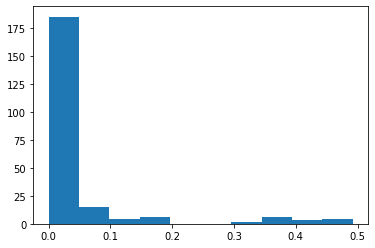

In [15]:
plt.hist(uncertainty)
plt.show()

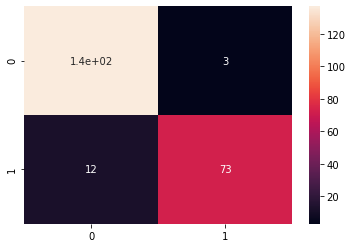

In [16]:
sns.heatmap(confusion_matrix(y_pool, predictions),annot=True)

#### Explain model using SHAP

Refer https://christophm.github.io/interpretable-ml-book/shap.html

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features

We call the SHAP explainer for linear models
shapely values produced have same dimensions as data passed

In [38]:
explainer = shap.Explainer(model, x_train,feature_dependence="independent")
shap_values_train = explainer.shap_values(x_train)
shap_values_pool = explainer.shap_values(x_pool)

In [39]:
shap_values_pool.shape

(225, 4813)

Explain a single positive prediction at 'index'

text   Congress shall make no law    abridging the freedom of speech     I believe the other   branches to clearly be implied  Why dont you   prediction:  1 actual  0


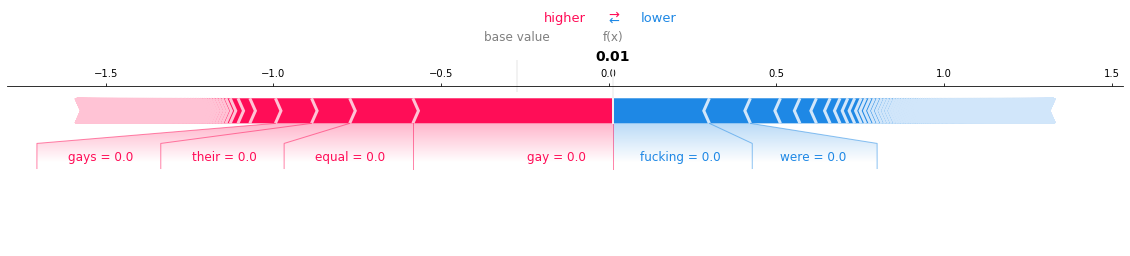

In [25]:
postive_index = 0
index = np.where(predictions==1)[0][postive_index]
print("text ", df_test[index], " prediction: ", predictions[index], "actual ", y_test[index])
shap.force_plot(explainer.expected_value, 
                               shap_values_pool[index,:], 
                               x_test[index,:], feature_names = tfid.get_feature_names(),
               matplotlib=True)

Explain the overall feature importance using summary

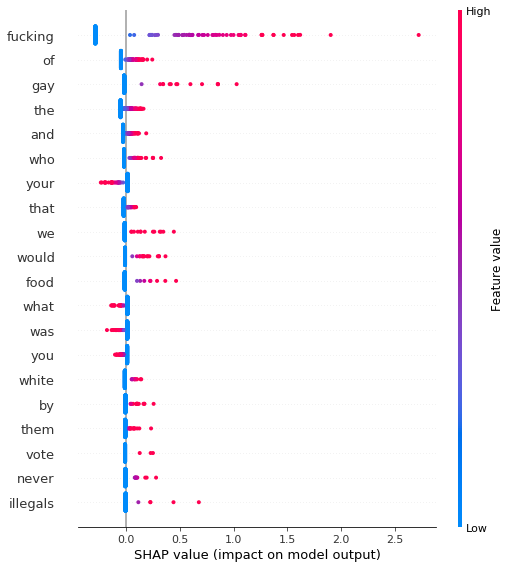

In [26]:
shap.summary_plot(shap_values_pool, x_pool, feature_names=tfid.get_feature_names())

In [44]:
?shap.plots.text

In [40]:
shap_values_pool

array([[-0., -0.,  0., ...,  0.,  0., -0.],
       [-0., -0.,  0., ...,  0.,  0., -0.],
       [-0., -0.,  0., ...,  0.,  0., -0.],
       ...,
       [-0., -0.,  0., ...,  0.,  0., -0.],
       [-0., -0.,  0., ...,  0.,  0., -0.],
       [-0., -0.,  0., ...,  0.,  0., -0.]])

In [45]:
type(explainer)

shap.explainers._linear.Linear

In [46]:
?shap._explanation.Explanation

In [66]:
shap_values_pool.shape, df_pool.shape

((225, 4813), (225,))

In [60]:
values = np.array([ 1.72879273e-07, -5.93766391e-02,  1.51735127e-02, -3.43937099e-02,
       -9.47782218e-02, -6.82953417e-02, -8.69272768e-02, -1.07482493e-02,
       -2.64857828e-02, -2.38219221e-02, -2.89288481e-02,  4.90835113e-03,
       -4.06696518e-02, -2.55540209e-03, -2.70076116e-02, -3.46219857e-02,
       -5.99554377e-03, -6.91925903e-02, -9.71120792e-03,  1.57645325e-02,
       -3.80367656e-02,  1.84232538e-07])

base_values =-2.7718377113342285

data = ['', 'If ', 'you ', 'don', 't ', 'understand ', 'what ', 'transgender ', 'is  ', 'go ', 'talk ', 'to ', 'your ', 'family ', 'doctor  ', 'They ', 'cover ', 'it ', 'in ', 'medical ', 'school', '']

In [61]:
sample = shap._explanation.Explanation(values=values, data=data, base_values=base_values)

In [62]:
shap.plots.text(sample)

#### Clustering data
We are going to cluster the training data using SHAP explanations (shapely space)
SHAP clustering works by clustering on Shapley values of each instance. 
This means that you cluster instances by explanation similarity.

In [ ]:
n_clusters = 50
kmeans = KMeans(n_clusters= n_clusters, n_jobs=-1, max_iter=600)
kmeans.fit(shap_values_pool)

In [ ]:
homogeneity_score( y_pool, kmeans.labels_), v_measure_score(y_pool, kmeans.labels_)

We use cosine distance instead of euclidean distance to measure the similarity between the documents.
As the size of the document increases, the number of common words (euclidean) tend to increase 
even if the documents talk about different topics. The cosine similarity helps overcome this fundamental flaw 
and finds the similarity irrespective of size.

https://www.machinelearningplus.com/nlp/cosine-similarity/

In [ ]:
# Find similarity of each point in cluster to its centroid
similarity_to_center = []
for i, instance in enumerate(shap_values_pool):
    cluster_label = kmeans.labels_[i] # cluster of this instance
    centroid = kmeans.cluster_centers_[cluster_label] # cluster center of the cluster of that instance
    similarity = 1-cosine(instance, centroid) # 1- cosine distance gives similarity
    similarity_to_center.append(similarity)
    
centroid_match = [None]*n_clusters
centroid_indices =[None]*n_clusters
for i, instance in enumerate(shap_values_pool):
    cluster_label = kmeans.labels_[i]     
    if centroid_match[cluster_label] is None or similarity_to_center[i] > centroid_match[cluster_label]:
        centroid_indices[cluster_label] = i
        centroid_match[cluster_label] = similarity_to_center[i]

#### Visualize clusters

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=20)
principals = tsne.fit_transform(shap_values_pool)

In [ ]:
data = []
colorscale = [[0, 'mediumturquoise'], [1, 'salmon']]
collect = dict()
sizes = []
color = ['hsl(' + str(h) + ',80%' + ',50%)' for h in np.linspace(0, 255, n_clusters)]
df_final_labels = pd.DataFrame()
for cluster_id in np.unique(kmeans.labels_):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)    
    
    cluster_text = df_pool[cluster_indices]
    center_index = centroid_indices[cluster_id]
    center_text = df_pool[center_index]
    sizes.append(len(cluster_indices[0]))
    df_cluster = pd.DataFrame({'text': cluster_text})
    df_cluster['cluster_id'] = cluster_id
    df_cluster['centroid'] = False
    df_cluster = df_cluster.append({'text':center_text, 'cluster_id':cluster_id,
                                    'centroid':True }, ignore_index=True)
    df_final_labels = pd.concat([df_final_labels, df_cluster])

    cp = principals[cluster_indices]
    data.append(go.Heatmap(x=cp[:, 0],
                           y=cp[:, 1],
                           z=uncertainty[cluster_indices],
                           name='uncertainity map',
                           visible=True,
                           showscale=False,
                           colorscale=colorscale,
                                         ))
    data.append(go.Scatter(x = cp[:,0],
                   y = cp[:,1],
                   mode='markers',                    
                hovertext=cluster_text,
                            marker=dict(color=color[cluster_id],
                                                   size=10),
                           name = 'cluster '+ str(cluster_id)
                          ))
    data.append(go.Scatter(x = [principals[center_index, 0]],
                   y = [principals[center_index, 1]],
                   mode='markers',  
                           marker=dict(color=color[cluster_id],
                                                   size=15,
                                                   line=dict(color='black', width=5)),
                           name = 'centroid cluster '+ str(cluster_id),
                           visible='legendonly',
                           
                          ))
    collect[cluster_id] = df_pool[cluster_indices]
    
fig = go.Figure(data=data)
fig.show()
df_final_labels.to_csv('df_input.csv')

In [ ]:
sizes

#### Analyze uncertainty within clusters

In [ ]:
data = []
ranges = []
for cluster_id in np.unique(kmeans.labels_):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)    
    uncertainty_cluster = uncertainty[cluster_indices]
    rng = np.max(uncertainty_cluster)- np.min(uncertainty_cluster)
    print(cluster_id, "range ", rng)
    ranges.append(rng)
    print(y_pool[cluster_indices])
    print("\n")
    data.append(go.Histogram(x=uncertainty_cluster, name=str(cluster_id), showlegend=True,visible='legendonly'))
fig = go.Figure(data=data)
url=py.plot(fig, filename='clusters_50', sharing='public')

In [ ]:
max_uncertain_indices = (-uncertainty).argsort()[:20]
y_pool[max_uncertain_indices], uncertainty[max_uncertain_indices]

In [ ]:
cluster_id = 8
cluster_indices = np.where(kmeans.labels_ == cluster_id)    
d = {'text' : df_pool[cluster_indices], 'uncertainty': uncertainty[cluster_indices], 'label': y_pool[cluster_indices]}

pd.DataFrame(d)


In [ ]:
i=cluster_indices[0][10]
shap.force_plot(explainer.expected_value, shap_values_pool[i,:], x_pool[i,:], feature_names = tfid.get_feature_names(),
               matplotlib=True)

In [ ]:
cluster_indices

#### Find optimal cluster size

In [ ]:
homogeneity_scores = []
v_measure_scores = []
completeness_scores = []
n_iters = 10
ranges = list(range(10, 110, 10))
for k in ranges:
    vavg = 0
    havg = 0
    cavg = 0
    for i in range(n_iters):
        kmeans = KMeans(n_clusters= n_clusters, n_jobs=-1)
        kmeans.fit(shap_values_pool)
        v = v_measure_score(labels_pred=kmeans.labels_, labels_true=y_pool) 
        h = homogeneity_score(labels_pred=kmeans.labels_, labels_true=y_pool) 
        c = completeness_score(labels_pred=kmeans.labels_, labels_true=y_pool) 
        vavg += v
        havg += h
        cavg += c
    homogeneity_scores.append(havg/n_iters)
    v_measure_scores.append(vavg/n_iters)
    completeness_scores.append(cavg/n_iters)
    print(k, "done")



In [ ]:
data = [go.Scatter(x=ranges, y=homogeneity_scores, mode="lines", name="homogeneity"),
        go.Scatter(x=ranges, y=v_measure_scores, mode="lines", name="v_measure"),
        go.Scatter(x=ranges, y=completeness_scores, mode="lines", name="completeness")
        ]
fig = go.Figure(data=data)
fig.update_layout(xaxis_title="no of clusters")
fig.show()

#### Add centroid of each cluster to the training set and retrain the model

In [ ]:
train_indices_new = np.append(train_indices, centroid_indices)


In [ ]:
model1 = SVC( max_iter=max_iter, C=C, kernel='linear')
x_train_new = x[train_indices_new]
y_train_new = y[train_indices_new]
model1.fit(x_train_new, y_train_new)

In [ ]:
model1.score(x_train_new, y_train_new), model1.score(x_test, y_test)

In [ ]:
predictions1 = model1.predict(x_test)
f1_score(y_test, predictions1)

In [ ]:
accuracy_score(y_test, predictions1)

#### Add entire x_pool back to training instead of just centroids

In [ ]:
train_indices_full = np.append(train_indices, pool_indices)

In [ ]:
model2 = SVC(max_iter=max_iter, C=C, kernel='linear')
x_train_full = x[train_indices_full]
y_train_full = y[train_indices_full]
model2.fit(x_train_full, y_train_full)
model2.score(x_train_full, y_train_full), model2.score(x_test, y_test)

In [ ]:
predictions2 = model2.predict(x_test)
f1_score(y_test, predictions2)

In [ ]:
accuracy_score(y_test, predictions2)

#### Compare

In [ ]:
print("Model with 20% train ", f1_score(y_test, predictions))
print("Model with 20% train + center ", f1_score(y_test, predictions1))
print("Model with 20% train + 60% pool ", f1_score(y_test, predictions2))

In [ ]:
print("Model with 20% train ", accuracy_score(y_test, predictions))
print("Model with 20% train + center ", accuracy_score(y_test, predictions1))
print("Model with 20% train + 60% pool ", accuracy_score(y_test, predictions2))